In [ ]:
import pandas as pd
import zipfile

# Define the path to the zip file
zip_file_path = '/content/parkinsons.zip'

# Initialize a dictionary to store the DataFrames
dataframes = {}

# Extract and read each file from the ZIP
with zipfile.ZipFile(zip_file_path, 'r') as z:
    for file_name in z.namelist():
        if file_name.endswith('.data'):
            with z.open(file_name) as f:
                dataframes[file_name] = pd.read_csv(f)
                # print(f"Loaded {file_name}:")
                print(dataframes[file_name].info())
                print(dataframes[file_name].head(), "\n")
        elif file_name.endswith('.names'):
            with z.open(file_name) as f:
                dataframes[file_name] = f.read().decode('utf-8')
                # print(f"Loaded {file_name}:\n{dataframes[file_name]}\n")

# Access individual DataFrames
parkinsons_df = dataframes['parkinsons.data']
parkinsons_updrs_df = dataframes['telemonitoring/parkinsons_updrs.data']

# You can now work with the loaded DataFrames as needed
print("DataFrame for parkinsons.data:")
print(parkinsons_df.head())

print("DataFrame for parkinsons_updrs.data:")
print(parkinsons_updrs_df.head())

# Optionally: Save the DataFrames to CSV files if needed
parkinsons_df.to_csv('parkinsons.csv', index=False)
parkinsons_updrs_df.to_csv('parkinsons_updrs.csv', index=False)

print("DataFrames saved as CSV files.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              195 non-null    object 
 1   MDVP:Fo(Hz)       195 non-null    float64
 2   MDVP:Fhi(Hz)      195 non-null    float64
 3   MDVP:Flo(Hz)      195 non-null    float64
 4   MDVP:Jitter(%)    195 non-null    float64
 5   MDVP:Jitter(Abs)  195 non-null    float64
 6   MDVP:RAP          195 non-null    float64
 7   MDVP:PPQ          195 non-null    float64
 8   Jitter:DDP        195 non-null    float64
 9   MDVP:Shimmer      195 non-null    float64
 10  MDVP:Shimmer(dB)  195 non-null    float64
 11  Shimmer:APQ3      195 non-null    float64
 12  Shimmer:APQ5      195 non-null    float64
 13  MDVP:APQ          195 non-null    float64
 14  Shimmer:DDA       195 non-null    float64
 15  NHR               195 non-null    float64
 16  HNR               195 non-null    float64
 1

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Drop the 'name' column (ID) if it exists
if 'name' in parkinsons_df.columns:
    parkinsons_df.drop(columns=['name'], inplace=True)

# Define features and target variable
X = parkinsons_df.drop(columns=['status'])
y = parkinsons_df['status']

# Check for missing values
print("Missing values in the dataset:\n", parkinsons_df.isnull().sum())

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("\nData preprocessing completed. Ready for model training.")

Missing values in the dataset:
 MDVP:Fo(Hz)         0
MDVP:Fhi(Hz)        0
MDVP:Flo(Hz)        0
MDVP:Jitter(%)      0
MDVP:Jitter(Abs)    0
MDVP:RAP            0
MDVP:PPQ            0
Jitter:DDP          0
MDVP:Shimmer        0
MDVP:Shimmer(dB)    0
Shimmer:APQ3        0
Shimmer:APQ5        0
MDVP:APQ            0
Shimmer:DDA         0
NHR                 0
HNR                 0
status              0
RPDE                0
DFA                 0
spread1             0
spread2             0
D2                  0
PPE                 0
dtype: int64

Data preprocessing completed. Ready for model training.


In [ ]:
import numpy as np
from scipy import stats
from sklearn.feature_selection import mutual_info_classif

class EnhancedCustomKNN:
    def __init__(self, k_range=(3, 7), weights='adaptive'):
        self.k_range = k_range
        self.weights = weights
        self.optimal_k = None
        self.feature_weights = None

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        # Calculate feature weights before optimizing k
        self._compute_feature_weights(X, y)
        self._optimize_k(X, y)

    def _optimize_k(self, X, y):
        best_score = 0
        best_k = self.k_range[0]
        for k in range(self.k_range[0], self.k_range[1] + 1):
            score = self._cross_validate(X, y, k)
            if score > best_score:
                best_score = score
                best_k = k
        self.optimal_k = best_k

    def _cross_validate(self, X, y, k):
        n_splits = 5
        scores = []
        for i in range(n_splits):
            mask = np.zeros(len(X), dtype=bool)
            mask[np.random.choice(len(X), len(X) // n_splits, replace=False)] = True
            X_val, y_val = X[mask], y[mask]
            X_train, y_train = X[~mask], y[~mask]
            y_pred = self._predict(X_val, X_train, y_train, k)
            scores.append(np.mean(y_pred == y_val))
        return np.mean(scores)

    def _compute_feature_weights(self, X, y):
        self.feature_weights = mutual_info_classif(X, y)
        # Replace None or NaN values with 0
        self.feature_weights = np.nan_to_num(self.feature_weights)
        self.feature_weights[self.feature_weights == None] = 0
        self.feature_weights /= np.sum(self.feature_weights)

    def predict(self, X):
        return self._predict(X, self.X_train, self.y_train, self.optimal_k)

    def _predict(self, X, X_train, y_train, k):
        y_pred = []
        for x in X:
            distances = np.sqrt(np.sum(((X_train - x) * self.feature_weights) ** 2, axis=1))
            k_indices = np.argsort(distances)[:k]
            k_nearest_labels = y_train.iloc[k_indices]

            if self.weights == 'uniform':
                y_pred.append(stats.mode(k_nearest_labels, keepdims=False).mode)
            elif self.weights == 'distance':
                k_distances = distances[k_indices]
                weights = 1 / (k_distances + 1e-8)
                weighted_votes = np.bincount(k_nearest_labels, weights=weights)
                y_pred.append(np.argmax(weighted_votes))
            elif self.weights == 'adaptive':
                k_distances = distances[k_indices]
                weights = np.exp(-k_distances)
                weighted_votes = np.bincount(k_nearest_labels, weights=weights)
                y_pred.append(np.argmax(weighted_votes))

        return np.array(y_pred)

    def score(self, X_test, y_test):
        return np.mean(self.predict(X_test) == y_test)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

# Initialize models and store their accuracies
models = {
    # "Random Forest": RandomForestClassifier(random_state=42),
    "Support Vector Machine": SVC(random_state=42),
    "Scikit-learn KNN": KNeighborsClassifier(n_neighbors=3, weights='uniform'),
    "Enhanced Custom KNN": EnhancedCustomKNN(k_range=(3, 7), weights='adaptive'),
    "Naive Bayes": GaussianNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42)
}

# Store accuracies for comparison
accuracy_results = {}

# Train and evaluate each model
for model_name, model in models.items():
    model.fit(X_train, y_train)  # Train the model

    if model_name == "Custom KNN":
        y_pred = model.predict(X_test)
        accuracy = model.score(X_test, y_test)
    else:
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)

    accuracy_results[model_name] = accuracy
    print(f"Model: {model_name}")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print("=" * 50)

Model: Support Vector Machine
[[ 3  4]
 [ 0 32]]
              precision    recall  f1-score   support

           0       1.00      0.43      0.60         7
           1       0.89      1.00      0.94        32

    accuracy                           0.90        39
   macro avg       0.94      0.71      0.77        39
weighted avg       0.91      0.90      0.88        39

Model: Scikit-learn KNN
[[ 6  1]
 [ 2 30]]
              precision    recall  f1-score   support

           0       0.75      0.86      0.80         7
           1       0.97      0.94      0.95        32

    accuracy                           0.92        39
   macro avg       0.86      0.90      0.88        39
weighted avg       0.93      0.92      0.93        39

Model: Enhanced Custom KNN
[[ 5  2]
 [ 0 32]]
              precision    recall  f1-score   support

           0       1.00      0.71      0.83         7
           1       0.94      1.00      0.97        32

    accuracy                           0.95 

Confusion Matrix for Support Vector Machine:
[[ 3  4]
 [ 0 32]]


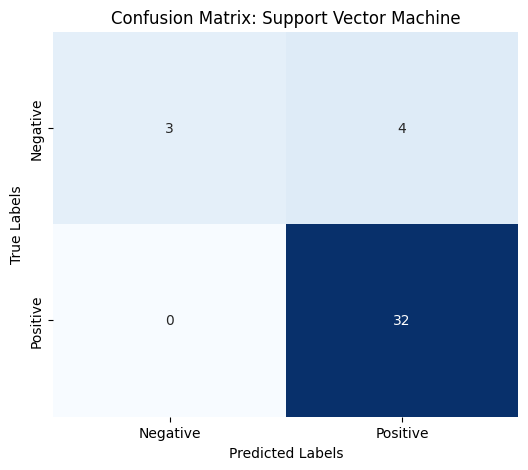

Confusion Matrix for Scikit-learn KNN:
[[ 6  1]
 [ 2 30]]


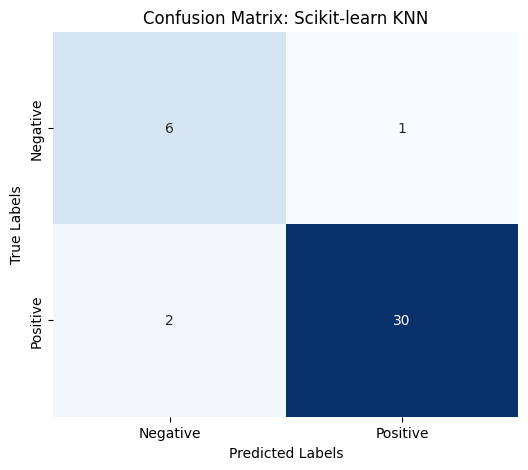

Confusion Matrix for Enhanced Custom KNN:
[[ 5  2]
 [ 0 32]]


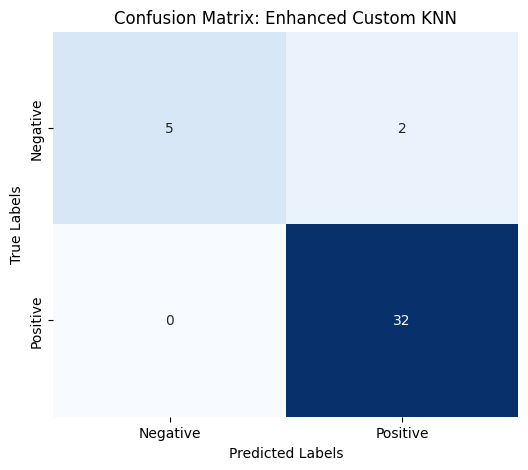

Confusion Matrix for Naive Bayes:
[[ 4  3]
 [ 8 24]]


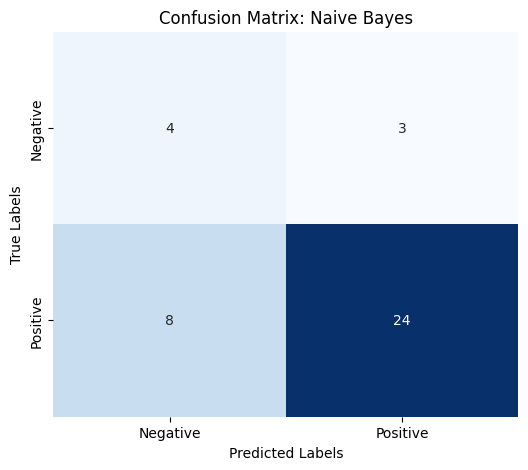

Confusion Matrix for Logistic Regression:
[[ 3  4]
 [ 0 32]]


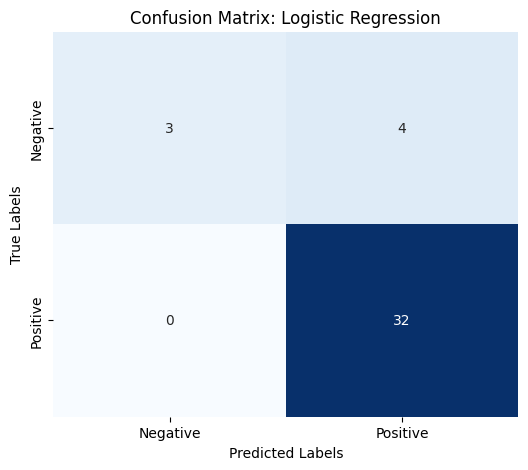

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    """
    Plots the confusion matrix for a given model.
    """
    cm = confusion_matrix(y_true, y_pred)  # Compute confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

# Train and evaluate each model
for model_name, model in models.items():
    model.fit(X_train, y_train)  # Train the model

    # Predict based on model type
    if model_name == "Enhanced Custom KNN":
        y_pred = model.predict(X_test)
    else:
        y_pred = model.predict(X_test)

    # Print confusion matrix and plot it
    print(f"Confusion Matrix for {model_name}:")
    print(confusion_matrix(y_test, y_pred))  # Print confusion matrix
    plot_confusion_matrix(y_test, y_pred, model_name)  # Plot confusion matrix
    print("=" * 50)


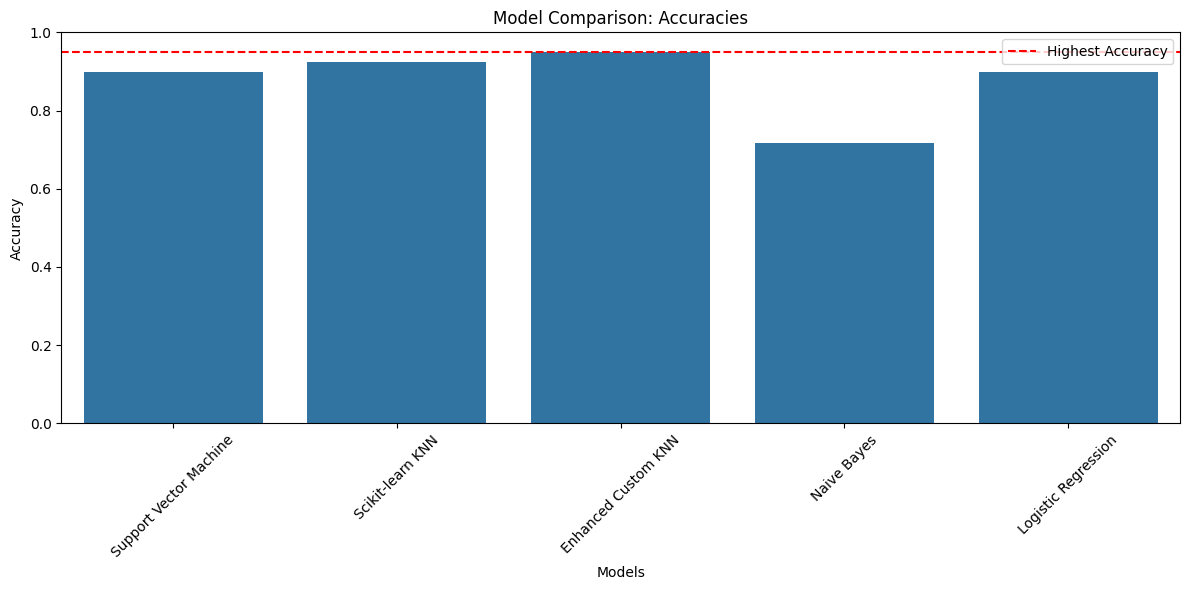

The model with the highest accuracy is: Enhanced Custom KNN with an accuracy of 0.95
Saved Support Vector Machine model.
Saved Scikit-learn KNN model.
Saved Enhanced Custom KNN model.
Saved Naive Bayes model.
Saved Logistic Regression model.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Visualization of Model Accuracies
plt.figure(figsize=(12, 6))
sns.barplot(x=list(accuracy_results.keys()), y=list(accuracy_results.values()))
plt.title('Model Comparison: Accuracies')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
plt.axhline(y=max(accuracy_results.values()), color='r', linestyle='--', label='Highest Accuracy')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Identify the model with the highest accuracy
best_model_name = max(accuracy_results, key=accuracy_results.get)
best_model_accuracy = accuracy_results[best_model_name]
print(f"The model with the highest accuracy is: {best_model_name} with an accuracy of {best_model_accuracy:.2f}")

# Optional: Save the trained models
for model_name, model in models.items():
    if model_name != "Custom KNN":  # Skip saving custom model as it's not compatible with joblib
        joblib.dump(model, f"{model_name.replace(' ', '_')}.joblib")
        print(f"Saved {model_name} model.")